In [146]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sp
from scipy import signal
from lea_utils import APRBS,dados_exp_LEA,plot_exogenous,plot_states
#%matplotlib tk

Definindo as variáveis simbólicas

0


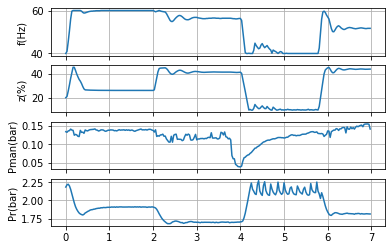

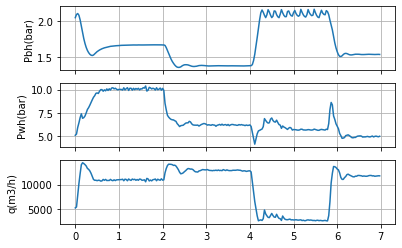

In [147]:

# =========================================================================
#  Define as entradas do BCS LEA   
# =========================================================================
#freq = Cexp.referencia_frequencia_inversor(1:nsim)*0.1;                   % [Hz] frequencia de operacao
intervalo=np.array([int(1.5*3600),int(2.5*3600)])
intervalo=np.array([int(0*3600),int(7.6*3600)])
intervalo=np.array([int(0*3600),int(7*3600)])
LEA=dados_exp_LEA("./dados_experimentais/Dados_BCSLEA_20210818.mat",intervalo)
#Perturbações#######################################
pman=LEA['pressao_manifold_coriolis']*1e5
pres=LEA['pressao_reservatorio']*1e5
#Estados############################################
q=LEA['vazao']/3600
pbh=LEA['pressao_fundo']
pwh=LEA['pressao_choke']
#Entradas exógenas manipuladas######################
zc = LEA['valvula_pneumatica_topo']#[0:nsim]
fk = LEA['referencia_frequencia_inversor']#[0:nsim]
#Valores iniciais####################################
pm_0=pman[0]
pr_0=pres[0]
u_0=np.array([fk[0],zc[0],pm_0,pr_0]) #entrada inicial
u_exp=np.array([fk,zc,pman*1e5,pres*1e5])#entradas experimentais
x_0=np.array([pbh[0]*1e5,pwh[0]*1e5,q[0]])
#####################################################
nsim=LEA['tempo']+1
ts=LEA['Ts']
tempo_hora = np.arange(0,nsim*ts,ts)/3600
ex_plot=plot_exogenous(tempo_hora,[fk,zc,pman,pres])
ex_states=plot_states(tempo_hora,[pbh*1e5,pwh*1e5,q*3600])



In [148]:
#Entradas - conforme binder e pavlov
#========================================
#========================================
# Limites das variáveis para normalização LEA
#========================================
flim=[35,65]
zlim=[5,70]
pbhlim=(1e5,2.5e5) 
pwhlim=(2e5,11e5) 
qlim=(0.1/3600,5/3600)
def Lim_c(x):
    return x[1]-x[0]
pbc=Lim_c(pbhlim)
pwc=Lim_c(pwhlim)
qc=Lim_c(qlim)
pbmin=pbhlim[0]
pwmin=pwhlim[0]
qmin=qlim[0]
#xss = np.float32(np.array([8311024.82175957,2990109.06207437,0.00995042241351780]))
x0=np.array([pbmin,pwmin,qmin])#,0,0])
xc=np.array([pbc,pwc,qc])#,1,1])
xss=x_0
xssn = (xss-x0)/xc
#### Transforma para unidades de engenharia (bar, m3/h)
xscale=np.array([1/1e5,1/1e5,3600])
####
print(f"X estacionário_norm = {xssn}")
print(f"X estacionário = {xss}")
print(f"X_0 = {x_0}")
(x_0-x0)/xc

X estacionário_norm = [0.69708347 0.34393671 0.27783165]
X estacionário = [2.04562521e+05 5.09543037e+05 4.05937521e-04]
X_0 = [2.04562521e+05 5.09543037e+05 4.05937521e-04]


array([0.69708347, 0.34393671, 0.27783165])

In [149]:
# Criando simbolica
from casadi import MX,Function
from casadi import vertcat as csvertcat
from casadi import sum1,nlpsol,integrator
nx = 3; nu = 4;
x = MX.sym("x",nx); # Estados
u = MX.sym("u",nu); # Exogena
dudt_max = MX.sym("dudt_max",2); # Exogena
from lea_utils import mod
from lea_utils import model as ED

dfq_max = 0.5;    # m�xima varia��o em f/s
dzc_max = 1;      # máxima variação em zc
dx1,dx2,dx3,pin,H=ED.EDO(x,u)


num=[1,2,3]
len(num)//2

In [150]:
dxdt = csvertcat(dx1,dx2,dx3) 
# dxdt = casadi.vertcat(dpbhdt,dpwhdt,dqdt) 
Eq_Estado = Function('Eq_Estado',[x,u],[dxdt],
                     ['x','u'],['dxdt'])

In [151]:
y=csvertcat(pin,H);
ny = y.size1()
# Equações algébricas
sea_nl = Function('sea_nl',[x,u],[y,pin,H],\
                 ['x','u'],['y','pin','H']); # Sistema de Eq. Algebricas variaveis de sa�da

BCS={
     'x': x,
     'u': u,
     'y': y,
     'nx': nx,
     'nu': nu,
     'ny': ny,
     'NaoLinear': {'sedo_nl': Eq_Estado(x,u),
                   'sea_nl': sea_nl
                   }
}
#%% Calculo do estacionario
#% Func��o objetivo
dxdt_0 = Eq_Estado(BCS['x'], BCS['u']);
J = sum1(dxdt_0**2);
#% Otimizador
opt={
     'ipopt':{
         'print_level':0,
         'acceptable_tol':1e-8,
         'acceptable_obj_change_tol':1e-6,
         'max_iter':150
         },
     'print_time':0,
     }

opt['ipopt']['print_level']=0;# %0,3
opt['print_time']=0;
opt['ipopt']['acceptable_tol']=1e-8;
opt['ipopt']['acceptable_obj_change_tol']=1e-6;
opt['ipopt']['max_iter']=50;


In [152]:
#Encontrar o x que minimize J, dado u
MMQ = {'x':BCS['x'], 'f':J, 'p':BCS['u']} # variáveis, função custo, entradas
solver = nlpsol('solver', 'ipopt', MMQ, opt)
# Restrições das variaveis de decis�o
# minimo
args={
      'lbx': np.zeros((nx,1)),
# m�ximo
      'ubx':np.full((nx, 1), np.inf)
      }

# Solução do otimizador
sol=solver(x0=BCS['x'], lbx=args['lbx'], ubx=args['ubx'], p=BCS['u']);
yss=sea_nl(sol['x'],BCS['u'])
Estacionario = Function('Estacionario',[BCS['x'],BCS['u']],[sol['x']],['x0','uss'],['xss']);


In [153]:
BCS['Estacionario'] = Estacionario;
xss=x_0;uss=u_0
print(xss)
print(uss)
Estacionario(xssn,uss)*xc+x0


[2.04562521e+05 5.09543037e+05 4.05937521e-04]
[4.0000000e+01 2.0000000e+01 1.3393538e+04 2.1787500e+05]


DM([201969, 493378, 0.00042961])

In [154]:
# Definir variaveis manipuladas e controladas e disturbio externo
mv = [0,1]    #% [f, Zc]
pv = [0,1]  #% [pin, H]  #% [P, I]
#pv = [2,3];  #% [pin, H]
de = 2;      #% [pm]
tg = 2;      #% MV target
#% Parametros
sedo = {'x': BCS['x'], # Estados
        'p': BCS['u'], #Variáveis exogenas
        'ode': Eq_Estado(x,u) # SEDO (Gerado no bcs_settings)
        };

#% Criando o objeto p,ra integração da Eq_estado
opt = {'tf':ts,
       't0':0
       };   #% opções do integrador

In [155]:
int_odes = integrator('int_odes','cvodes',sedo,opt);
# objeto integrador
res = int_odes(x0=BCS['x'],p=BCS['u']);             #   % solução um passo a frente
npv = len(pv); nmv = len(mv);


In [156]:
# Criando o objeto para solução da equação de medição
Eq_medicao = Function('Eq_medicao',[BCS['x'],BCS['u']],[BCS['y'][pv]],['x','u'],['y']);
# Criacao do objeto para simulacao do BCS Eq de estado + Eq de Medicao
Modelo_Predicao = Function('Modelo_Predicao',[BCS['x'],BCS['u']],[res['xf'],Eq_medicao(res['xf'],BCS['u'])],['xk_1','uk_1'],['xk','yk']);
Modelo_Predicao2 = Function('Modelo_Predicao2',[BCS['x'],BCS['u']],[res['xf']],['xk_1','uk_1'],['xk']);

In [157]:
def degrau(valor,time_step,time_vector):
    v=np.zeros_like(time_vector)
    for i in np.arange(0,len(time_vector)):
        if time_vector[i]<time_step:
            v[i]=valor[0]
        else:
            v[i]=valor[1]

    return v


time = np.arange(0.5, 1.8*3600, ts)
zc2=degrau([25,42],1.5*3600,time)# exogenous input
pm2=degrau([0.12,0.12],1*3600,time)*1e5# exogenous input
f2=degrau([60,56.5],0.8*3600,time)# exogenous input
pr2=degrau([1.9,1.7],1.1*3600,time)*1e5# exogenous input
2.5*3600/ts


# tempo_hora=time
time.shape
ts

#plot_exogenous(time,[f2,zc2,pm2,pr2])

100

In [158]:
# fig3=plt.figure()
# label = ['Pman','Pr','f','z'];
# ax1=fig3.add_subplot(2,2,1)
# #ax1.plot(tempo_hora ,pman/1e5, label='Pman')
# #ax1.plot(tempo_hora ,output_signal/1e5, ':r')
# ax1.plot(tempo_hora ,pm2/1e5, '--k')
# ax1.set_ylabel(label[0])
# plt.grid(True)
# ax2=fig3.add_subplot(2,2,3)
# ax2.plot(tempo_hora,pr2/1e5, '--k')
# #ax2.plot(tempo_hora,pres/1e5, label='Pr')
# ax2.set_ylabel(label[1])

# plt.grid(True)
# ax3=fig3.add_subplot(2,2,2)
# #ax3.plot(tempo_hora,LEA['referencia_frequencia_inversor'], label='f')
# ax3.plot(tempo_hora,f2, '--k')
# ax3.set_ylabel(label[2])
# plt.grid(True)
# ax4=fig3.add_subplot(2,2,4)
# #ax4.plot(tempo_hora,LEA['valvula_pneumatica_topo'], label='z')
# ax4.set_ylabel(label[3])
# ax4.plot(tempo_hora,zc2, '--k')
# plt.grid(True)

In [159]:
# nsim=36

nstep = nsim
nsim=u_exp.shape[1]

a_range = [35,65]
b_range = [30,50] # periodo de retenção em cada amplitude

u_f,prbs=APRBS(a_range,b_range,nstep)
u_z,prbs=APRBS(a_range,b_range,nstep)
uk_1 = np.array([np.ones_like(u_z)*40,u_z]);
#uk_1 = np.array([frequencia,val_pneumatica,pman,pres]);
prfixo=1.8e5; pr2=np.ones_like(f2)*prfixo
pmfixo=0.12e5;pm2=np.ones_like(f2)*pmfixo
zfixo=35;zc2=np.ones_like(f2)*zfixo


#uk_1 = np.array([f2,zc2,pm2,pr2]);
# uk_1=u_exp;uss=u_0
uss=uss.reshape([4,1])

#uk_1 = np.array([frequencia,val_pneumatica,np.ones_like(frequencia)*0.12*1e5,np.ones_like(frequencia)*1.9*1e5]);
#uk_1 = np.array([u_f,u_z,np.ones_like(frequencia)*0.12*1e5,np.ones_like(frequencia)*1.9*1e5]);
#uk_1 = np.array([np.ones_like(frequencia)*30,np.ones_like(frequencia)*30,np.ones_like(frequencia)*0.12*1e5,np.ones_like(frequencia)*1.9*1e5]);
# uk_1 = np.array([u_f,u_z]);
#Uss e xss simples
uk_1=np.array([fk,zc,pman,pres])
#uss=np.array([30,30,0.12*1e5,1.9*1e5]);
xss=Estacionario(xssn,uss)
xss
xss=Estacionario(xss,uss)


In [160]:
xss
xss=Estacionario(xss,uss)
xss

DM([0.67979, 0.325976, 0.295224])

In [161]:
#xpk = Modelo_Predicao2(xssn,uss) #valores normalizados

xss=Estacionario(x_0,uss)
xpk = Modelo_Predicao2(xss,uss) #valores normalizados
Xk=xpk*xc+x0
Uk= uss

In [164]:
print("Simulação iniciada")
xi=tempo_hora
for k in range(1,nsim):
    xpk = Modelo_Predicao2(xpk,uk_1[:,k:k+1])
    #print(xpk)
    #print(uk_1[:,k:k+1])
    Xk = np.concatenate([Xk,xpk*xc+x0],axis=1) #desnormalizar x e preencher vetor
    Uk = np.concatenate([Uk,uk_1[:,k:k+1]],axis=1)
print("Ok.simulação concluida")


Simulação iniciada
Ok.simulação concluida


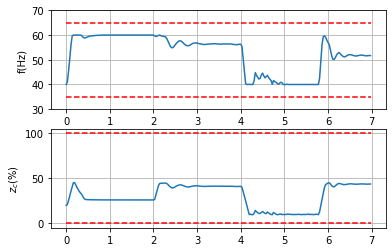

In [166]:
# #% Restrição
umin  = np.array([35, 0]); np.transpose(umin);  # lower bounds of inputs
umax  = np.array([65, 100]); np.transpose(umax); # upper bounds of inputs
dumax = np.array([0.5, dzc_max]); np.transpose(dumax);
fig2=plt.figure()
label = ['f(Hz)',r'$z_c$(%)'];
for iu in range(0,nmv):
    ax2=fig2.add_subplot(nmv,1,iu+1)
    ax2.plot(xi,Uk[iu,:].T, label='Medição')
    ax2.plot([0,xi[-1]],[umin[iu], umin[iu]],'--r')
    ax2.plot([0,xi[-1]],[umax[iu], umax[iu]],'--r', label='Restrição')
    ax2.set_ylabel(label[iu])
    #ax2.set(xlim=(xi[0], nsim*ts))
    if iu==0:
        ax2.set(ylim=(30, 70))

    plt.grid(True)


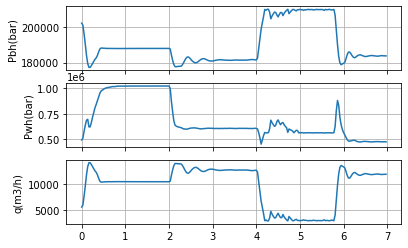

In [167]:
sim_states=[Xk[0,:]*1e5,Xk[1,:].T*1e5,Xk[2,:].T*3600]
plot_ss=plot_states(tempo_hora,sim_states)

No handles with labels found to put in legend.


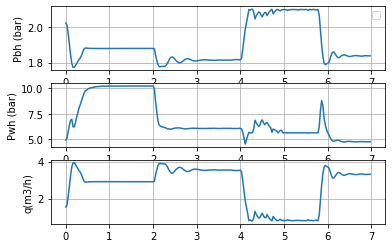

In [169]:
# fig3=plt.figure()
# label = ['Pbh (bar)','Pwh (bar)','q(m3/s)'];
# for iu in range(0,3):
#     ax3=fig3.add_subplot(3,1,iu+1)
#     if iu==2:
#         ax3.plot(xi,(Xk[iu,:].T)*3600, label='Medição')
#         #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
#         #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
#         ax3.set_ylabel(label[iu])
#         #ax3.set(xlim=(xi[0], nsim*ts))
#         # if iu==0:
#         #     #ax2.set(ylim=(30, 70))
#         #     print(iu)
#         plt.grid(True)
#     else:
#         ax3.plot(xi,Xk[iu,:].T/1e5, label='Medição')
#         #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
#         #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
#         ax3.set_ylabel(label[iu])
#         #ax3.set(xlim=(xi[0], nsim*ts))
#         # if iu==0:
#         #     #ax2.set(ylim=(30, 70))
#         #     print(iu)
#         plt.grid(True)

fig3=plt.figure()
label = ['Pbh (bar)','Pwh (bar)','q(m3/h)'];
for iu in range(0,3):
    ax3=fig3.add_subplot(3,1,iu+1)
    if iu==2:
        ax3.plot(xi,(Xk[iu,:].T*3600), label='Modelo')
        #ax3.plot(xi,(LEA['vazao']), ':r',label='Medição')
        #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
        #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
        ax3.set_ylabel(label[iu])
        #ax3.set(xlim=(xi[0], nsim*ts))
        # if iu==0:
        #     #ax2.set(ylim=(30, 70))
        #     print(iu)
        plt.grid(True)
    elif iu==0:
        ax3.plot(xi,Xk[iu,:].T/1e5)
        #ax3.plot(xi,LEA['pressao_fundo'],':r', label='Medição')
        #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
        #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
        ax3.set_ylabel(label[iu])
        #ax3.set(xlim=(xi[0], nsim*ts))
        # if iu==0:
        #     #ax2.set(ylim=(30, 70))
        #     print(iu)
        ax3.legend()
        plt.grid(True)
    else:
        ax3.plot(xi,Xk[iu,:].T/1e5)
        #ax3.plot(xi,LEA['pressao_choke'],':r', label='Medição')
        #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
        #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
        ax3.set_ylabel(label[iu])
        #ax3.set(xlim=(xi[0], nsim*ts))
        # if iu==0:
        #     #ax2.set(ylim=(30, 70))
        #     print(iu)
        plt.grid(True)
        


In [170]:
# fig1=plt.figure()
# label = [r'$p_{in}(bar)$','H(m)','P','I','qc','qr' ];
# for iy in range(0,npv):
#     ax = fig1.add_subplot(npv,1,iy+1)
#     #print(iy)
#     if iy == 0: # Pin
#         ax.plot(xi,(Yk[iy,:].T)/1e5, label='Medição')
#         #ax.plot(xi,Ymk[iy,:].T/1e5, label='EKF')
#         ax.set_ylabel(label[iy])
#         ax.set(xlim=(xi[0], nsim*ts))
#        # ax.set(ylim=(40,62))
#         plt.grid(True)
#     else: # H
#         ax.plot(xi,Yk[iy,:].T, label='Medição')
#         #ax.plot(xi,Ymk[iy,:].T,label='EKF')
#         ax.set_ylabel(label[iy])
#         ax.set(xlim=(xi[0], nsim*ts))
#        # ax.set(ylim=(580, 850))
#         plt.grid(True)
# #ax.plot(xi,Yk[2,:].T, label='EKF')
# ax.legend();
# ax.set_xlabel('Time (nT)')
# fig1.show()


In [171]:
# #exec(compile(open('envelope.py', "rb").read(), 'envelope.py', 'exec')) #% Roda arquivo com parâmetros do modelo BCS
# fig4,ax4=plt.subplots()
# plt.grid(True)
# #BCS['Envelope']['fig'](ax4); # grafico do envelope
# #
# # Evolução dentro do envelope
# ax4.plot(Xk[2,0:].T*3600,Yk[1,0:].T,'--k')
# ax4.plot(Xk[2,0]*3600,Yk[1,0],'o')#,'MarkerFaceColor',[0,1,0],'MarkerEdgeColor',[0,0,0])
# ax4.plot(Xk[2,-1]*3600,Yk[1,-1],'o')#,'MarkerFaceColor',[1,0,0],'MarkerEdgeColor',[0,0,0])
# ax4.annotate('t=0',
#              xy=(float(Xk[2,0]*3600),float(Yk[1,0])),
#              xytext=(float(Xk[2,0]*3600)-5,float(Yk[1,0])+10),
#              arrowprops=dict(facecolor='green', shrink=0.01))

# ax4.annotate('t='+str(nsim),
#              xy=(float(Xk[2,-1]*3600),float(Yk[1,-1])),
#              xytext=(float(Xk[2,-1]*3600)-7,float(Yk[1,-1])+10),
#              arrowprops=dict(facecolor='red', shrink=0.01))
# plt.show()



In [172]:
#np.savez('LEA_data_train-f.npz', t=xi, x1=Xk[0,:].T,x2=Xk[1,:].T,x3=Xk[2,:].T,zc=zc2,f=f2,pm=pm2,pr=pr2)

In [173]:
def ler_dados(str):
    with open(str, 'r') as f:
        d = f.readlines()
        epocas = np.zeros(len(d));
        tau = np.zeros(len(d));
        j = 0;
        data = []
        for i in d:
            k = i.rstrip().split(" ")
            data.append([float(i) if is_float(i) else i for i in k])
            epocas[j] = float(k[0])
            tau[j] = float(k[1])
            j += 1;
    
    return tau, epocas


In [174]:
qcc/qc

NameError: name 'qcc' is not defined